# Using Python to Access NCEI Archived NEXRAD Level 2 Data

This notebook shows how to access the THREDDS Data Server (TDS) instance that is serving up archived NEXRAD Level 2 data hosted on Amazon S3. The TDS provides a mechanism to query for available data files, as well as provides access to the data as native volume files, through OPeNDAP, and using its own CDMRemote protocol. Since we're using Python, we can take advantage of Unidata's Siphon package, which provides an easy API for talking to THREDDS servers.

**NOTE:** Due to data charges, the TDS instance in AWS only allows access to .edu domains. For other users interested in using Siphon to access radar data, you can access recent (2 weeks') data by changing the server URL below to: http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/

**But first!**
Bookmark these resources for when you want to use Siphon later!
+ [latest Siphon documentation](http://siphon.readthedocs.org/en/latest/)
+ [Siphon github repo](https://github.com/Unidata/siphon)
+ [TDS documentation](http://www.unidata.ucar.edu/software/thredds/current/tds/TDS.html)

Just a bit of initial set-up to import necessary libraries, use inline figures and quiet some warnings.

In [1]:
import matplotlib
import warnings
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shprd
import time
import sys

warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)
%matplotlib inline

MetPy is a Python package for meteorology (Documentation: http://metpy.readthedocs.org and GitHub: http://github.com/MetPy/MetPy). We import MetPy and use it to get the colortable and value mapping information for the NWS Reflectivity data.

In [2]:
from metpy.plots import ctables  # For NWS colortable
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

First we'll create an instance of RadarServer to point to the appropriate radar server access URL.

In [3]:
from siphon.radarserver import RadarServer
rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

We define some helper functions to make working with the data easier. One takes the raw data and converts it to floating point values with the missing data points appropriately marked. The other helps with converting the polar coordinates (azimuth and range) to Cartesian (x and y).

In [4]:
import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

The CDMRemote reader provides an interface that is almost identical to the usual python NetCDF interface. We pull out the variables we need for azimuth and range, as well as the data itself.

Then convert the raw data to floating point values and the polar coordinates to Cartesian.

MetPy is a Python package for meteorology (Documentation: http://metpy.readthedocs.org and GitHub: http://github.com/MetPy/MetPy). We import MetPy and use it to get the colortable and value mapping information for the NWS Reflectivity data.

Finally, we plot them up using matplotlib and cartopy. We create a helper function for making a map to keep things simpler later.

In [5]:
def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = ccrs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add coastlines
    ax.coastlines('50m', 'black', linewidth=2, zorder=2)

    # Grab state borders
    state_borders = cf.NaturalEarthFeature(
        category='cultural', name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
    
    return ax

Use the function to make a new map and plot a colormapped view of the data

## Download a collection of historical data

Make a query based on a longitude, latitude point and using a time range.

In [6]:
query = rs.query()
dt = datetime(2017, 4, 30, 12) # Our specified time
query.lonlat_point(-99.95, 37.76).time_range(dt, dt + timedelta(hours=2))

time_start=2017-04-30T12%3A00%3A00&time_end=2017-04-30T14%3A00%3A00&latitude=37.76&longitude=-99.95

Make the request to the THREDDS Data Server, which returns an instance of TDSCatalog; this handles parsing the returned XML information.

The TDS helpfully finds the closest station to that point specified by the lat/lon pair. The time range we request is also queried for data files occurring during the time window. We will likely obtain multiple datasets.

In [7]:
cat = rs.get_catalog(query)
cat.datasets

OrderedDict([('KDDC20170430_120002_V06',
              <siphon.catalog.Dataset at 0x7efc6c4dd950>),
             ('KDDC20170430_120607_V06',
              <siphon.catalog.Dataset at 0x7efc6c4dd9d0>),
             ('KDDC20170430_121212_V06',
              <siphon.catalog.Dataset at 0x7efc6c4dd990>),
             ('KDDC20170430_121817_V06',
              <siphon.catalog.Dataset at 0x7efc6c4dda10>),
             ('KDDC20170430_122422_V06',
              <siphon.catalog.Dataset at 0x7efc6c4dda50>),
             ('KDDC20170430_123026_V06',
              <siphon.catalog.Dataset at 0x7efc6c4dda90>),
             ('KDDC20170430_123631_V06',
              <siphon.catalog.Dataset at 0x7efc6c4ddad0>),
             ('KDDC20170430_124237_V06',
              <siphon.catalog.Dataset at 0x7efc6c4ddb10>),
             ('KDDC20170430_124842_V06',
              <siphon.catalog.Dataset at 0x7efc6c4ddb50>),
             ('KDDC20170430_125447_V06',
              <siphon.catalog.Dataset at 0x7efc6c4ddb90>),


Grab the first dataset so that we can get the longitude and latitude of the station and make a map for plotting. We'll go ahead and specify some longitude and latitude bounds for the map.

Loaded dataset successfully


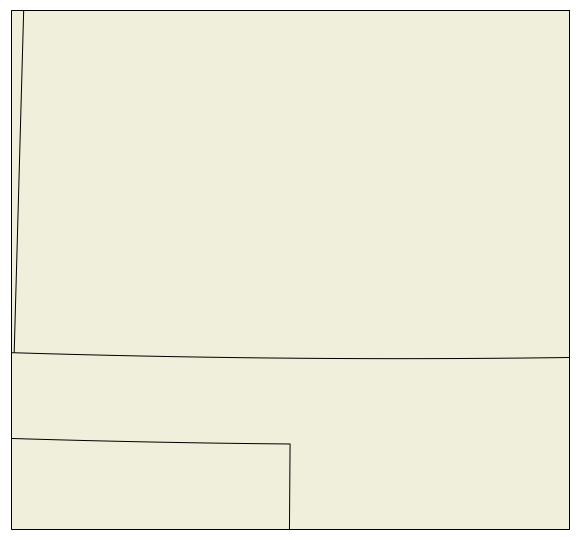

In [9]:
ds = list(cat.datasets.values())[0]
#print (ds)
process = 0
ok = 0
while ok == 0:
  ncount = 1
  while ncount <= 5:
    try:
      data = Dataset(ds.access_urls['CdmRemote'])
    except:  
      print "Caught an exception; will try URL again in 5 secs"
      sys.stdout.flush()
      time.sleep (5)
      ncount = ncount + 1
    else:
      ok = 1
      ncount = 10
  if (ncount == 6):
    print "Exceeded # of attempts to connect to remote server"
    sys.stdout.flush()
    process = 0
    ok = 1
  else:
    print "Loaded dataset successfully"
    process = 1

if process:        
  fig = plt.figure(figsize=(10, 10))
  ax = new_map(fig, -99.22, 37.88)

## Modify this to fit your case
# Set limits in lat/lon space
  ax.set_extent([-102, -98, 36, 39])

# Add ocean and land background
  ocean = cf.NaturalEarthFeature('physical', 'ocean', scale='50m',
                                            edgecolor='face',
                                            facecolor=cf.COLORS['water'])
  land = cf.NaturalEarthFeature('physical', 'land', scale='50m',
                                           edgecolor='face',
                                           facecolor=cf.COLORS['land'])
  ax.add_feature(ocean, zorder=-1)
  ax.add_feature(land, zorder=-1) 

Now we can loop over the collection of returned datasets and plot them. As we plot, we collect the returned plot objects so that we can use them to make an animated plot. We also add a timestamp for each plot.

In [10]:
meshes = []
for item in sorted(cat.datasets.items()):
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    ds = item[1]
    print (ds)
    process = 0
    ok = 0
    while ok == 0:
      ncount = 1
      while ncount <= 5:
        try:
          data = Dataset(ds.access_urls['CdmRemote'])
        except:  
          print "Caught an exception; will try URL again in 5 secs"
          sys.stdout.flush()
          time.sleep (5)
          ncount = ncount + 1
        else:
          ok = 1
          ncount = 10
      if (ncount == 6):
        print "Exceeded # of attempts to connect to remote server"
        sys.stdout.flush()
        process = 0
        ok = 1
      else:
        print "Loaded dataset successfully"
        process = 1

    if process:        
    # Pull out the data of interest
      sweep = 0
      rng = data.variables['distanceR'][:]
      az = data.variables['azimuthR'][sweep]
      ref_var = data.variables['Reflectivity']

    # Convert data to float and coordinates to Cartesian
      ref = raw_to_masked_float(ref_var, ref_var[sweep])
      x, y = polar_to_cartesian(az, rng)

    # Plot the data and the timestamp
      mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
      text = ax.text(0.65, 0.03, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    
    # Collect the things we've plotted so we can animate
      meshes.append((mesh, text))
print ('done')

Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
Loaded dataset successfully
done


Using matplotlib, we can take a collection of ``Artists`` that have been plotted and turn them into an animation. With matplotlib , this animation can be converted to HTML5 video viewable in the notebook. This may take a minute or two.

In [11]:
# Set up matplotlib to do the conversion to HTML5 video
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'
#matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'


# Create an animation
from matplotlib.animation import ArtistAnimation
ArtistAnimation(fig, meshes)